# Complex Valued Neural Networks for Audio

Complex valued neural networks have, for quite some time, been developed quietly in the background of all the research being done in deep learning. They seem to have several unique and desireable properties. For instance many researchers have put forward the claim that due to the nature of many tasks in signals processing involving complex numbers that CVNN's would be a natural fit for such problems. Indeed many results indicate that this is exactly the case. Audio in its raw form undoubtedly falls into this category. It is naturally presented as complex valued data. This is the driving force behind this small project, to determine if a complex valued neural network can more effectively solve tasks that deal with audio.

A small note: this notebook will require the use of two special libraries namely complexPyTorch, and pywavelets. Both can be installed via the pip package manager.

In [ ]:
pip install complexPyTorch

In [ ]:
pip install pywavelets

In [3]:
import pywt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from complexPyTorch.complexLayers import ComplexLinear, ComplexConv2d, ComplexConvTranspose2d, ComplexBatchNorm2d, ComplexDropout2d
from complexPyTorch.complexFunctions import complex_relu, complex_max_pool2d

# Wavelet Transforms

For those who are not familiar with wavelet transforms the following section should provide insight to the power and utility of these transforms. The Fourier Transform is a classical method to perform frequency analysis on signals. However, if the signal in question is non-stationary and its anaylsis requires considering both frequency and time components, different methods must be considered. Wavelet transforms are widely regarded as a valid approach to analyzing non-stationary signals, but importantly for this application the transform being selected produces complex coefficients.


Below is a simple example that highlights some of the qualities of a Continuous Morlet Wavelet Transform.

In [4]:
def gaussian(x, x0, sigma):
    return np.exp(-np.power((x - x0) / sigma, 2.0) / 2.0)


def make_chirp(t, t0, a):
    frequency = (a * (t + t0)) ** 2
    chirp = np.sin(2 * np.pi * frequency * t)
    return chirp, frequency


# generate signal
time = np.linspace(0, 1, 2000)
chirp1, frequency1 = make_chirp(time, 0.2, 9)
chirp2, frequency2 = make_chirp(time, 0.1, 5)
chirp = chirp1 + 0.6 * chirp2
chirp *= gaussian(time, 0.5, 0.2)

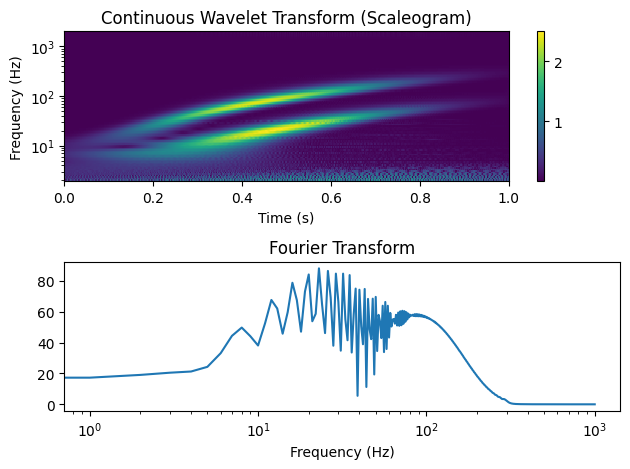

In [5]:
# perform CWT
wavelet = "cmor1.5-1.0"
# logarithmic scale for scales, as suggested by Torrence & Compo:
widths = np.geomspace(1, 1024, num=100)
# widths = np.arange(1, 500)
sampling_period = np.diff(time).mean()
cwtmatr, freqs = pywt.cwt(chirp, widths, wavelet, sampling_period=sampling_period)
# absolute take absolute value of complex result
cwtmatr = np.abs(cwtmatr[:-1, :-1])

# plot result using matplotlib's pcolormesh (image with annoted axes)
fig, axs = plt.subplots(2, 1)
pcm = axs[0].pcolormesh(time, freqs, cwtmatr)
axs[0].set_yscale("log")
axs[0].set_xlabel("Time (s)")
axs[0].set_ylabel("Frequency (Hz)")
axs[0].set_title("Continuous Wavelet Transform (Scaleogram)")
fig.colorbar(pcm, ax=axs[0])

# plot fourier transform for comparison
from numpy.fft import rfft, rfftfreq

yf = rfft(chirp)
xf = rfftfreq(len(chirp), sampling_period)
plt.semilogx(xf, np.abs(yf))
axs[1].set_xlabel("Frequency (Hz)")
axs[1].set_title("Fourier Transform")
plt.tight_layout()

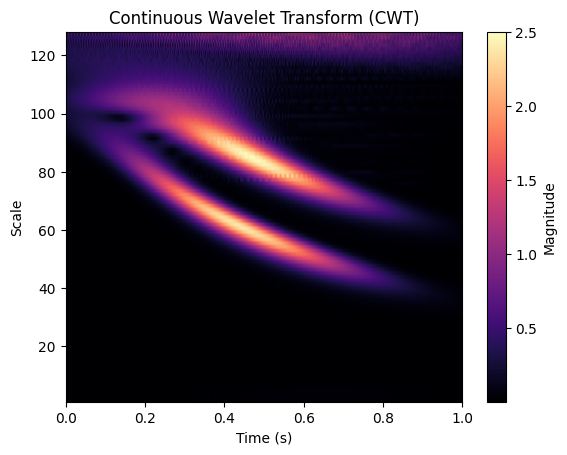

In [6]:
plt.imshow(cwtmatr, aspect='auto', extent=[0, 1, 1, 128], cmap='magma', origin='lower')
plt.colorbar(label='Magnitude')
plt.xlabel('Time (s)')
plt.ylabel('Scale')
plt.title('Continuous Wavelet Transform (CWT)')
plt.show()

In [8]:
complexCoef, freqs = pywt.cwt(chirp, widths, wavelet, sampling_period=sampling_period)

In [9]:
complexCoef.shape


(100, 2000)

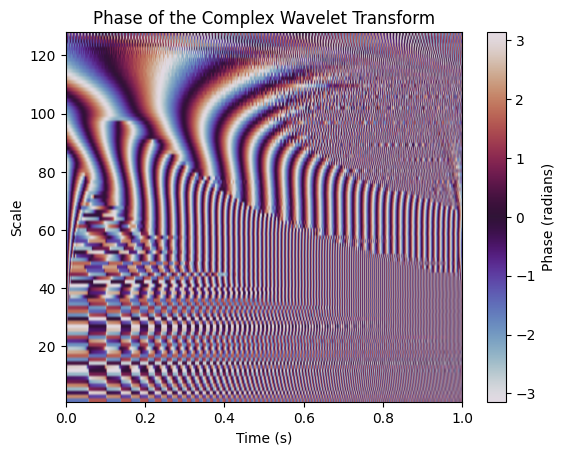

In [10]:
phase = np.angle(complexCoef)

# Plot phase as a function of time and scale
plt.imshow(phase, aspect='auto', extent=[0, 1, 1, 128], cmap='twilight', origin='lower')
plt.colorbar(label='Phase (radians)')
plt.xlabel("Time (s)")
plt.ylabel("Scale")
plt.title("Phase of the Complex Wavelet Transform")
plt.show()

# Application to ocean audio

Lets use the same wavelet transform on a small section of audio that contains a whale upcall.

In [11]:
from scipy.io import wavfile

# Step 1: Read the WAV file
file_path = "whale.wav"  # Change to your file path
fs, signal = wavfile.read(file_path)

# If stereo, convert to mono by averaging channels
if len(signal.shape) > 1:
    signal = np.mean(signal, axis=1)

In [12]:
interval = 188, 191

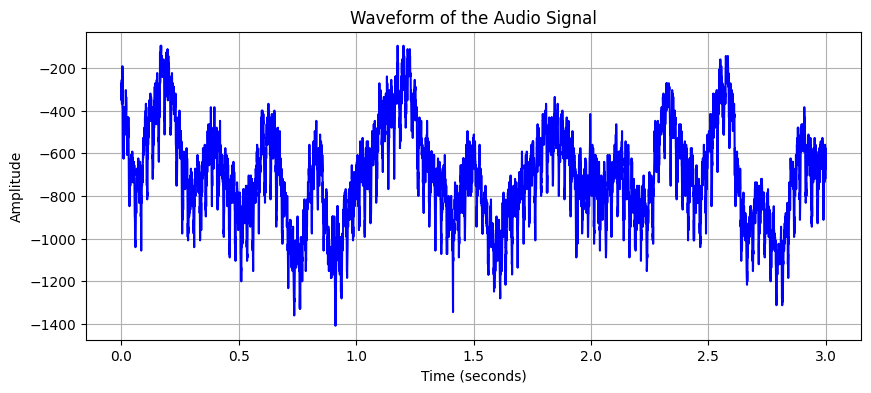

In [13]:
# Step 3: Create time array for plotting
time = np.linspace(0, len(signal[interval[0]*fs:interval[1]*fs]) / fs, num=len(signal[interval[0]*fs:interval[1]*fs]))

# Step 4: Plot the waveform
plt.figure(figsize=(10, 4))
plt.plot(time, signal[interval[0]*fs:interval[1]*fs], color='b')
plt.xlabel("Time (seconds)")
plt.ylabel("Amplitude")
plt.title("Waveform of the Audio Signal")
plt.grid()
plt.show()

In [14]:
signal = signal / np.max(np.abs(signal))

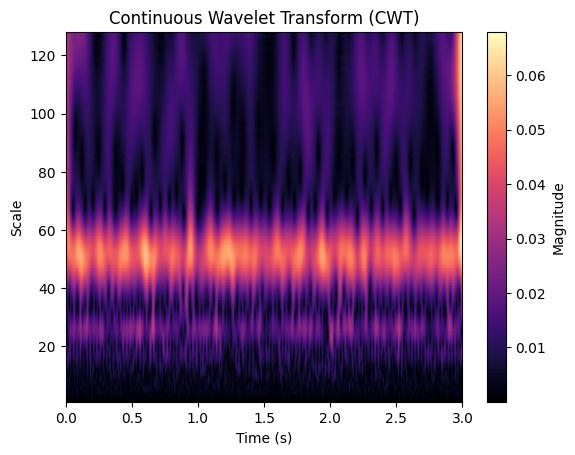

In [24]:
# Generate a 3-second signal
t = np.linspace(0, 3, 3 * fs, endpoint=False)

# Perform Continuous Wavelet Transform
scales = np.arange(1, 128)  # Scale range
#scales = np.geomspace(1, 128, num=100)  # Logarithmic scale for scales
coefficients, frequencies = pywt.cwt(signal[interval[0]*fs:interval[1]*fs], scales, "cmor1.5-1.0", sampling_period=1/fs)

# Plot the CWT result
plt.imshow(np.abs(coefficients), aspect='auto', extent=[0, 3, 1, 128], cmap='magma', origin='lower')
plt.colorbar(label='Magnitude')
plt.xlabel('Time (s)')
plt.ylabel('Scale')
plt.title('Continuous Wavelet Transform (CWT)')
plt.show()


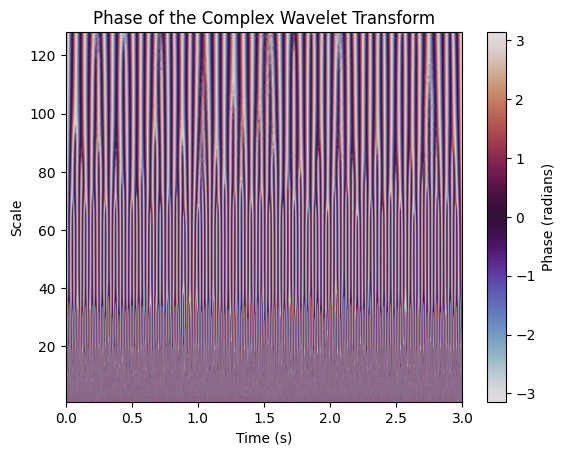

In [25]:
phase = np.angle(coefficients)

# Plot phase as a function of time and scale
plt.imshow(phase, aspect='auto', extent=[0, 3, 1, 128], cmap='twilight', origin='lower')
plt.colorbar(label='Phase (radians)')
plt.xlabel("Time (s)")
plt.ylabel("Scale")
plt.title("Phase of the Complex Wavelet Transform")
plt.show()

# Creating our Complex Valued Neural Network

Lets create a basic CVNN model to test the ability to handle this data. In the current form below this is just a proof of concept to show that the wav files can be transformed then the complex coefficients can be used in a fully complex convolutional network.

In [ ]:
# TODO: Create a data-loader for batches of raw audio.
# Each transformed audio slice is 100 rows x 2000 columns


In [26]:
# It may make more sense to do the transform in the data loader portion.

def get_cwt(x, B, C, fs):
  wavelet = "cmor"+f"{B}-{C}"
  widths = np.geomspace(1, 1024, num=100)
  time = np.linspace(0, 3, 3 * fs, endpoint=False)
  sampling_period = np.diff(time).mean()
  cwtmatr, freqs = pywt.cwt(x, widths, wavelet, sampling_period=sampling_period)
  return cwtmatr

In [35]:
# compCoef = get_cwt(chirp, 1.5, 1, 2000)

In [38]:
test_input = torch.from_numpy(coefficients).type(torch.complex64)

In [39]:
test_input.shape

torch.Size([127, 6000])

In [29]:
test_input[0]

tensor([ 8.3835e-06+0.0027j,  2.5347e-04+0.0014j,  2.5287e-05+0.0006j,
         ..., -1.9314e-04-0.0003j,  1.6464e-04+0.0001j,
         7.2063e-04-0.0030j])

In [42]:
import math

class CVNN(nn.Module):
  def __init__(self, embed_dim=64, output_size=2, hidden_size=64):
    super(CVNN, self).__init__()

    self.layer1 = ComplexConv2d(1, embed_dim, kernel_size=(5,5), stride=(1,2), padding=1)
    self.batchnorm1 = ComplexBatchNorm2d(embed_dim)
    self.layer2 = ComplexConv2d(embed_dim, hidden_size, kernel_size=(3,3), stride=(1,1), padding=1)
    self.batchnorm2 = ComplexBatchNorm2d(hidden_size)
    self.layer3 = ComplexLinear(1486016, hidden_size)
    self.layer4 = ComplexLinear(hidden_size, output_size)

  def forward(self, x):

    # x = self.get_cwt(x, 1.5, 1, 2000)
    x = complex_relu(self.layer1(x))
    x = complex_max_pool2d(x, 2, 2)
    x = self.batchnorm1(x)
    x = complex_relu(self.layer2(x))
    x = complex_max_pool2d(x, 2, 2)
    x = self.batchnorm2(x)
    x = torch.flatten(x, 1)
    x = complex_relu(self.layer3(x))
    x = self.layer4(x)
    x = x.abs()
    #probs = F.softmax(x, dim=-1)
    #dist = torch.distributions.Categorical(probs)
    #class_label = dist.sample()
    #log_prob = dist.log_prob(class_label)

    return x

In [43]:
model = CVNN()

In [40]:
test_input = test_input.unsqueeze(0).unsqueeze(0)

In [44]:
model.forward(test_input)

tensor([[0.6331, 0.3613]], grad_fn=<AbsBackward0>)